In [128]:
import os
import struct

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import nibabel as nib

import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')

import cv2

N_SLIDES  = 176
N_WEIGHTS = 2
N_CASES   = 10
N_ANGLES  = 20

TOT_FILE  = N_SLIDES * N_WEIGHTS * N_CASES * N_ANGLES

def load_dataset():

  filename = os.path.join('~', 'data_NAMIC', 'psnr_ssim_rotate_orig.csv')

  df = pd.read_csv(filename)

  assert len(df) == TOT_FILE

  weights = df['weight'].unique()
  scales  = df['scale'].unique()

  dataframe_list = []
  for w in weights:
    for s in scales:
      w_cond = df['weight'] == w
      s_cond = df['scale'] == s

      dataframe_list.append(df[w_cond & s_cond])

  # order : [t2, 2] [t2, 4] [t1, 2] [t1, 4]
  return [d.reset_index(drop=True) for d in dataframe_list]

def build_filename(case, weight, scale, slide, angle):
  
  root = os.path.join(os.path.expanduser('~'), 'data_NAMIC')
  orig = os.path.join(root, 'orig', weight, f'{case}_{weight}.nii') 

  sr = os.path.join(root, weight, f'{case}_{weight}_{scale}lr_bc_gauss_sr', f'sample_{slide:03}_{angle:03}.bin')
  bc = os.path.join(root, weight, f'{case}_{weight}_{scale}lr_bc_gauss_bc', f'sample_{slide:03}.bin')

  return orig, sr, bc

def load_bin(filename, dtype):

  with open(filename, 'rb') as f:

    h, w, c = struct.unpack('iii', f.read(12))
    out = np.fromfile(f, dtype=dtype, offset=0).reshape(h, w, c)
  
  return out

def load_images(origName, srName, bcName)
  
  orig = nib.load(origName).get_fdata()
  sr   = load_bin(srName, 'float32')
  bc   = load_bin(bcName, 'float64')[:,:,0]  

  
def name_switch(df):
  
  if df is df_x2_t2:
    return 'model edsrx2 in t2'

  elif df is df_x2_t1:
    return 'model edsrx2 in t1'

  elif df is df_x4_t2:
    return 'model wdsrx4 in t2'

  elif df is df_x4_t1:
    return 'model wdsrx4 in t1'

  else:
    raise ValueError('dt is wrong')

df_x2_t2, df_x4_t2, df_x2_t1, df_x4_t1 = load_dataset()

assert df_x2_t2['weight'].unique() == ['t2']
assert df_x4_t2['weight'].unique() == ['t2']
assert df_x2_t1['weight'].unique() == ['t1']
assert df_x4_t1['weight'].unique() == ['t1']
assert df_x2_t1['scale'].unique() == [2]
assert df_x2_t2['scale'].unique() == [2]
assert df_x4_t1['scale'].unique() == [4]
assert df_x4_t2['scale'].unique() == [4]

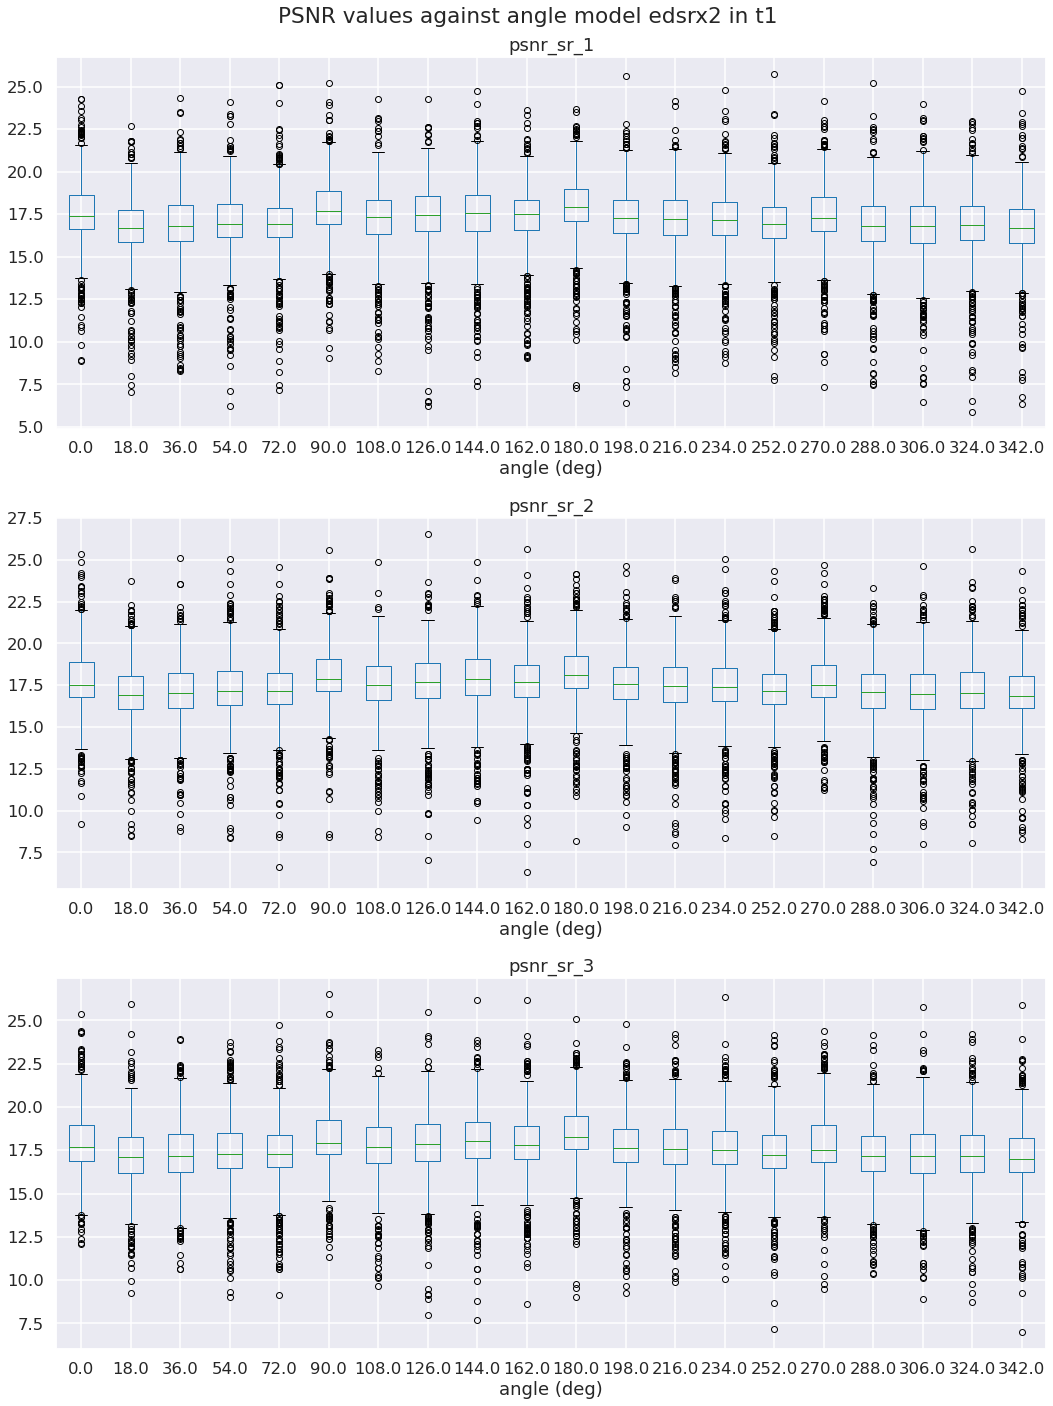

In [107]:
# start from simply x2_t1 for example

dt = df_x2_t1

name = name_switch(dt)

fig, row = plt.subplots(3, 1, figsize=(15, 20))

for i, ax in enumerate(row) :
  dt.boxplot(ax=ax, column='psnr_sr_{}'.format(i+1), by='angle (deg)')

fig.suptitle(f'PSNR values against angle {name}')

plt.tight_layout()
plt.show()

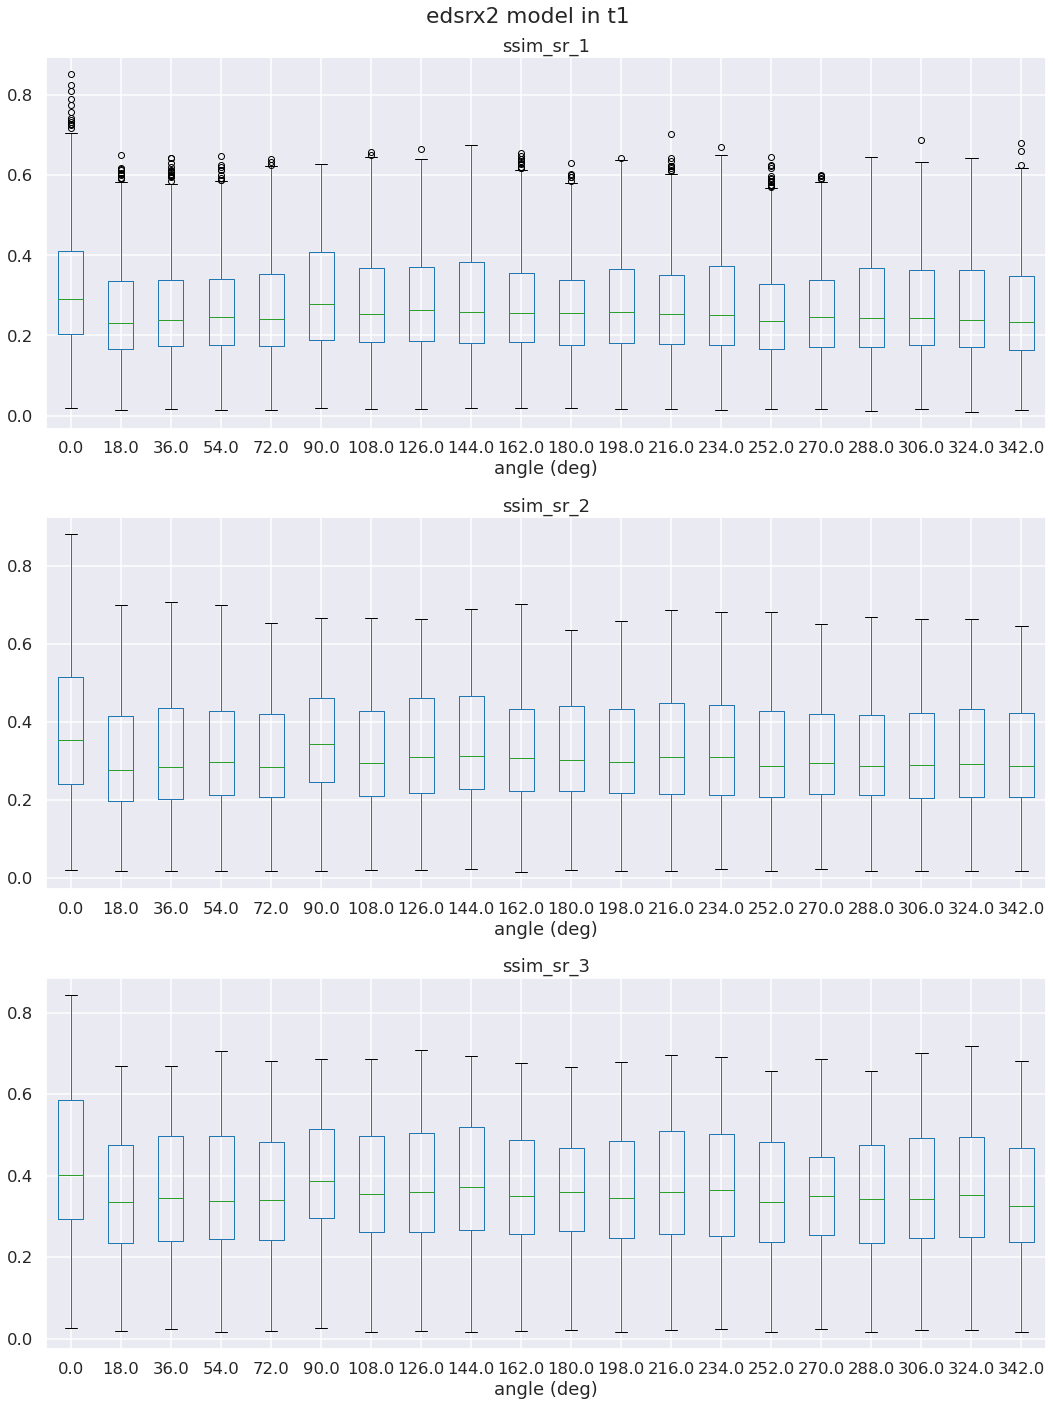

In [58]:
# ssim  boxplotting for edsr and 

dt = df_x2_t1

name = name_switch(dt)

fig, row = plt.subplots(3, 1, figsize=(15, 20))

for i, ax in enumerate(row) :
  dt.boxplot(ax=ax, column='ssim_sr_{}'.format(i+1), by='angle (deg)')

fig.suptitle('edsrx2 model in t1')
  
plt.tight_layout()
plt.show()

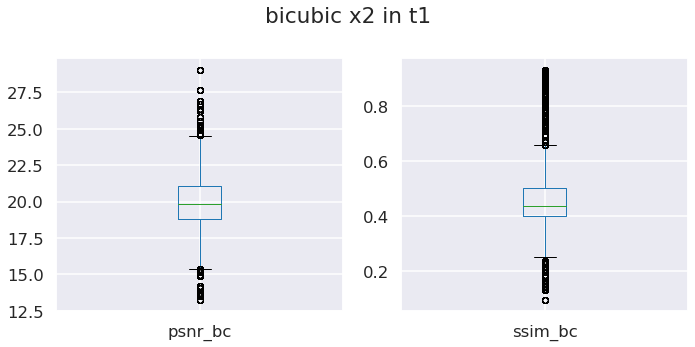

In [115]:
# bc boxplot

dt = df_x2_t1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

dt.boxplot(ax=ax1, column='psnr_bc')
dt.boxplot(ax=ax2, column='ssim_bc')

fig.suptitle('bicubic x2 in t1')
  
plt.tight_layout()
plt.show()

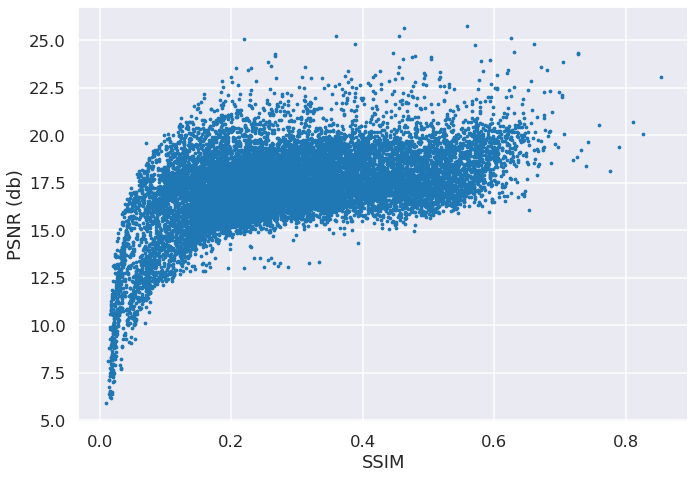

In [75]:
# graph psnr-ssim. The other cases are very different

dt = df_x2_t1
name = name_switch(dt)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

dt.plot.scatter(ax=ax, x='ssim_sr_1', y='psnr_sr_1', marker='.')
ax.set_xlabel('SSIM')
ax.set_ylabel('PSNR (db)')

plt.tight_layout()
plt.show()

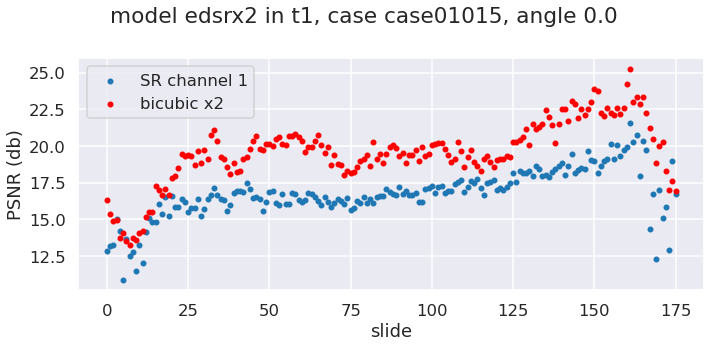

In [87]:
# scatter for value of psnr separated per scale and angle

dt = df_x2_t1
name = name_switch(dt)

case = 'case01015'
ang  = 0.
chan = 1

angle_cond = dt['angle (deg)'] == ang
case_cond  = dt['case'] == case

dt = dt[angle_cond & case_cond]

fig, ax = plt.subplots(1,1, figsize=(10, 5))
dt.plot.scatter(x='slide', y=f'psnr_sr_{chan}', ax=ax,    label=f'SR channel {chan}')
dt.plot.scatter(x='slide', y='psnr_bc', ax=ax, color='r', label=f'bicubic {name.split(" ")[1].split("r")[1]}')

ax.set_ylabel('PSNR (db)')
ax.legend()

fig.suptitle(f'{name}, case {case}, angle {ang}')
plt.tight_layout()
plt.show()

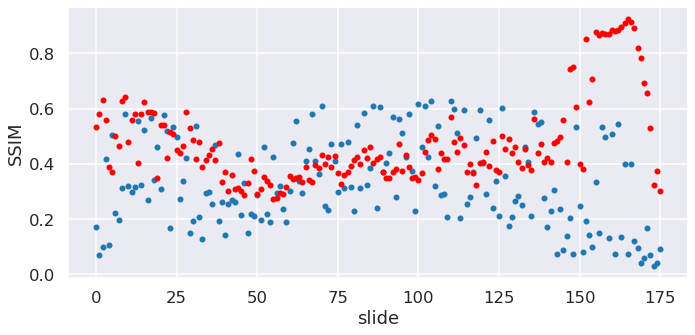

In [7]:
# scatter for value of ssim separated per case and angle

dt = df_x2_t1

angle_cond = dt['angle (deg)'] == 90
case_cond  = dt['case'] == 'case01011'

dt = dt[angle_cond & case_cond]

fig, ax = plt.subplots(1,1, figsize=(10, 5))
dt.plot.scatter(x='slide', y='ssim_sr_1', ax=ax)
dt.plot.scatter(x='slide', y='ssim_bc', ax=ax, color='r')

ax.set_ylabel('SSIM')

plt.tight_layout()
plt.show()

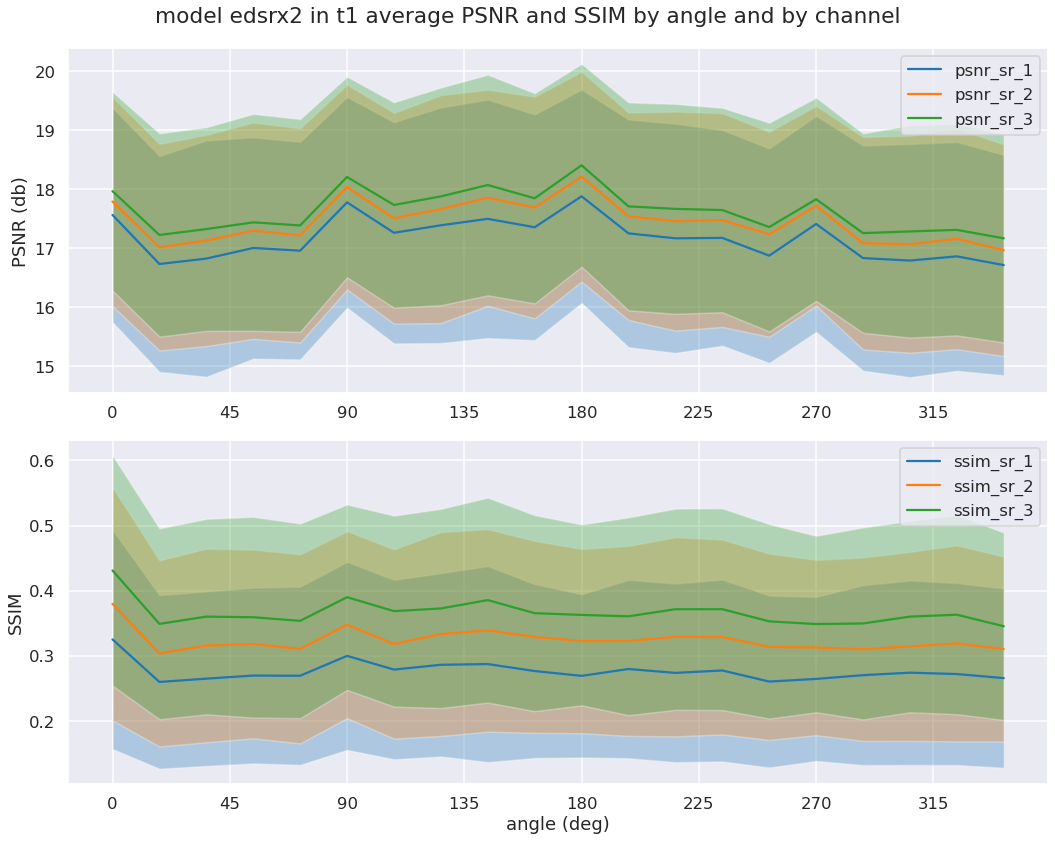

In [71]:
# plot of mean psnr and ssim as function of angle

dt = df_x2_t1
name = name_switch(dt)

byangle = dt.groupby('angle (deg)')

avg = byangle.mean()
std = byangle.std() 

x = np.arange(0, 360, 18)
x_tick = np.arange(0, 360, 45)

min_val = avg - std 
max_val = avg + std

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

for i in range(3):
  lab = f'psnr_sr_{i+1}'
  ax1.plot(x, avg[lab], label=lab)
  ax1.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)
  
ax1.legend()
ax1.set_ylabel('PSNR (db)')
ax1.set_xticks(x_tick)

for i in range(3):
  lab = f'ssim_sr_{i+1}'
  ax2.plot(x, avg[lab], label=lab)
  ax2.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)

ax2.set_xlabel('angle (deg)')
ax2.set_ylabel('SSIM')
ax2.set_xticks(x_tick)
ax2.legend()

fig.suptitle(name + ' average PSNR and SSIM by angle and by channel')
plt.tight_layout()
plt.show()

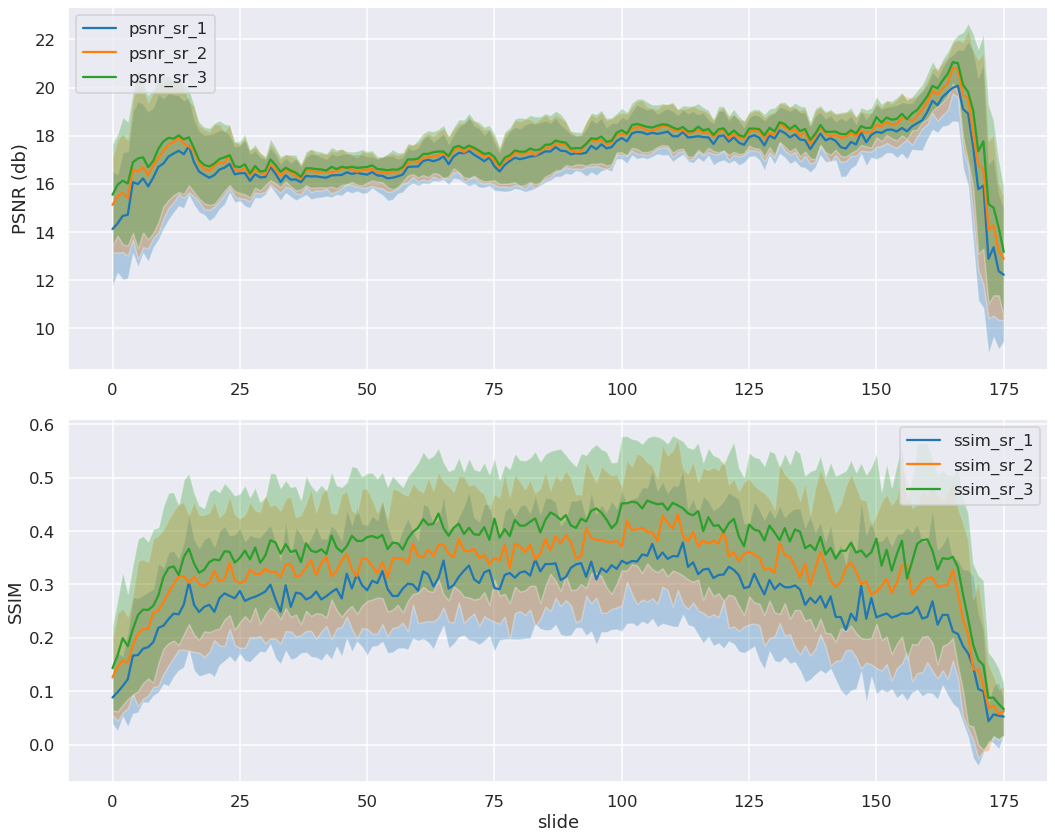

In [79]:
# same as above for angles

dt = df_x2_t1
name = name_switch(dt)

byangle = dt.groupby('slide')

avg = byangle.mean()
std = byangle.std() 

x = np.arange(0, 176, 1)

min_val = avg - std 
max_val = avg + std

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

for i in range(3):
  lab = f'psnr_sr_{i+1}'
  ax1.plot(x, avg[lab], label=lab)
  ax1.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)
  
ax1.legend()
ax1.set_ylabel('PSNR (db)')

for i in range(3):
  lab = f'ssim_sr_{i+1}'
  ax2.plot(x, avg[lab], label=lab)
  ax2.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)

ax2.set_xlabel('slide')
ax2.set_ylabel('SSIM')
ax2.legend()

plt.tight_layout()
plt.show()

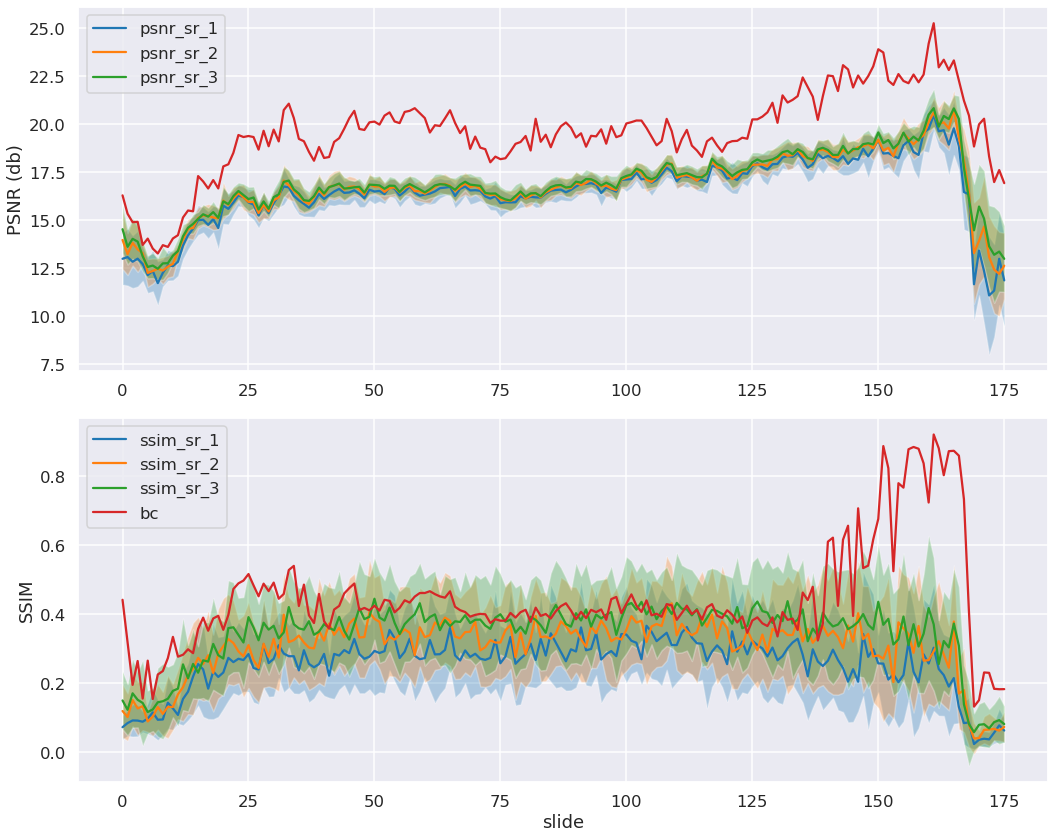

In [111]:
# analysis on case01015, image available for t1 for bc, srx2 and srx4

dt = df_x2_t1
name = name_switch(dt)
case = 'case01015'

dt = dt[dt['case'] == case]

## Boxplot essentially the same

## Plot grouped by slide
byangle = dt.groupby('slide')

avg = byangle.mean()
std = byangle.std() 

x = np.arange(0, 176, 1)

min_val = avg - std 
max_val = avg + std

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

for i in range(3):
  lab = f'psnr_sr_{i+1}'
  ax1.plot(x, avg[lab], label=lab)
  ax1.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)
  
ax1.legend()
ax1.set_ylabel('PSNR (db)')

ax1.plot(x, avg['psnr_bc'], label='bc')

for i in range(3):
  lab = f'ssim_sr_{i+1}'
  ax2.plot(x, avg[lab], label=lab)
  ax2.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)

ax2.plot(x, avg['ssim_bc'], label='bc')
ax2.set_xlabel('slide')
ax2.set_ylabel('SSIM')
ax2.legend()

plt.tight_layout()
plt.show()


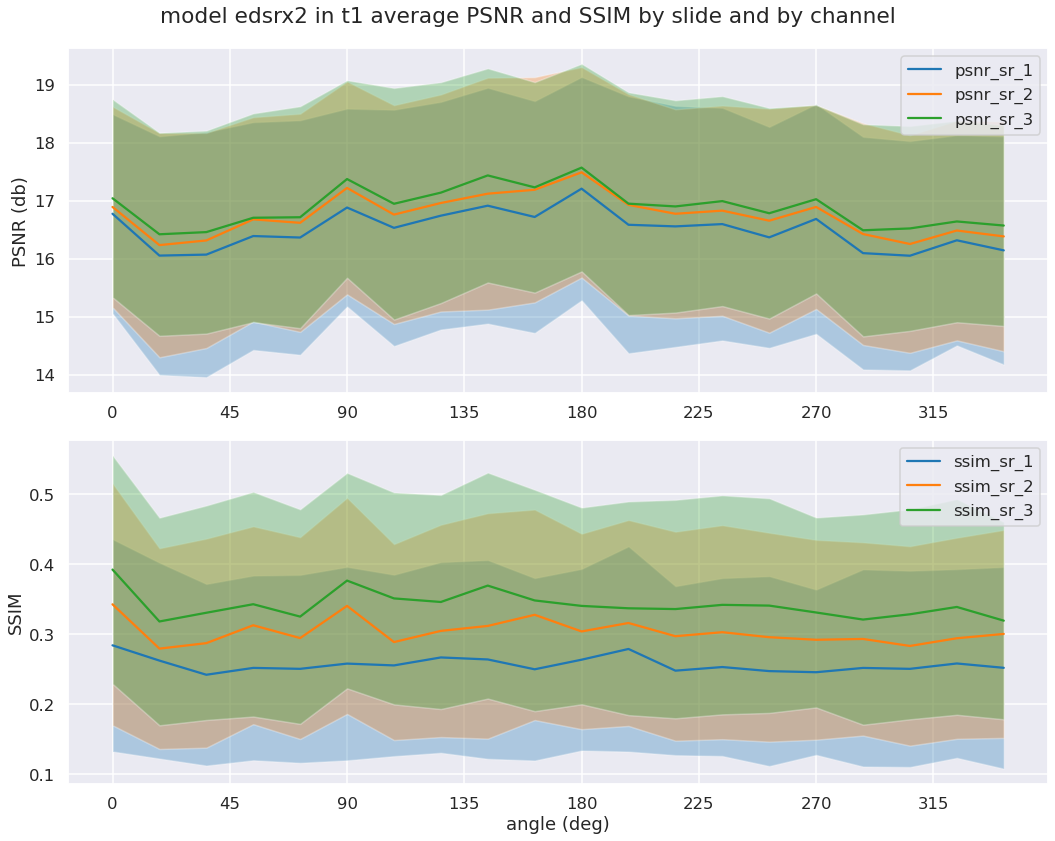

In [110]:
# same as above with 

dt = df_x2_t1
name = name_switch(dt)
case = 'case01015'

dt = dt[dt['case'] == case]

byangle = dt.groupby('angle (deg)')

avg = byangle.mean()
std = byangle.std() 

x = np.arange(0, 360, 18)
x_tick = np.arange(0, 360, 45)

min_val = avg - std 
max_val = avg + std

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

for i in range(3):
  lab = f'psnr_sr_{i+1}'
  ax1.plot(x, avg[lab], label=lab)
  ax1.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)
  
ax1.legend()
ax1.set_ylabel('PSNR (db)')
ax1.set_xticks(x_tick)

for i in range(3):
  lab = f'ssim_sr_{i+1}'
  ax2.plot(x, avg[lab], label=lab)
  ax2.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)

ax2.set_xlabel('angle (deg)')
ax2.set_ylabel('SSIM')
ax2.set_xticks(x_tick)
ax2.legend()

fig.suptitle(name + ' average PSNR and SSIM by slide and by channel')
plt.tight_layout()
plt.show()

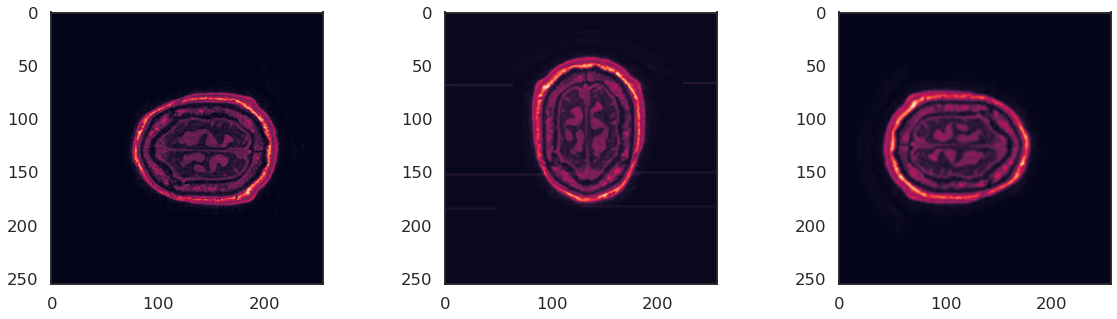

In [149]:
# show some images for case01015

case  = 'case01015'
weight = 't1'

sns.set_style('white')

angle = 0.
slide = 150
angle = 0
scale  = 2

origName, srName, bcName = build_filename(case, weight, scale, slide, angle)



orig = nib.load(origName).get_fdata()[:,:,slide]
sr   = load_bin(srName, 'float32')[:,:,2]
bc   = load_bin(bcName, 'float64')[:,:,0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

ax1.imshow(orig)
ax2.imshow(sr)
ax3.imshow(bc)